# 트랜스포머

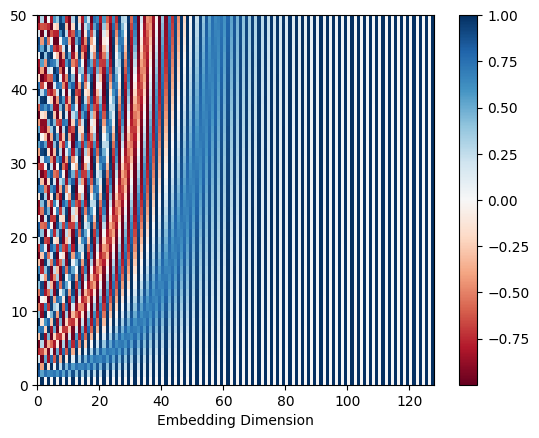

In [1]:
# 7.1 위치 인코딩
import math
import torch
from torch import nn
from matplotlib import pyplot as plt

class PositionalEncoding(nn.Module):
  # 임베딩 차원 & 최대 시퀀스를 입력받음
  def __init__(self, d_model, max_len, dropout=0.1):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)

    # sin cos 함수로 위치 인코딩을 계산
    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(
        torch.arange(0, d_model, 2)*(-math.log(10000.0)/d_model)
    )
    pe = torch.zeros(max_len, 1, d_model)
    pe[:, 0, 0::2] = torch.sin(position * div_term)
    pe[:, 0, 1::2] = torch.cos(position * div_term)
    self.register_buffer("pe",pe)

  def forward(self, x):
    x = x + self.pe[: x.size(0)]
    return self.dropout(x)

encoding = PositionalEncoding(d_model=128, max_len=50)

plt.pcolormesh(encoding.pe.numpy().squeeze(),cmap="RdBu")
plt.xlabel("Embedding Dimension")
plt.xlim((0,128))
plt.colorbar()
plt.show()

In [2]:
pip install torchdata torchtext portalocker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
# 7.2 데이트세트 다운로드 및 전처리
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

SRC_LANGUAGE = "de"
TGT_LANGUAGE = "en"
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ["<unk>", "<pad>", "<bos>", "<eos>"]

token_transform = {
    SRC_LANGUAGE: get_tokenizer("spacy", language="de_core_news_sm"),
    TGT_LANGUAGE: get_tokenizer("spacy", language="en_core_web_sm"),
}

def generate_tokens(text_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}
    for text in text_iter:
        yield token_transform[language](text[language_index[language]])

print("Token Transform:")
print(token_transform)

vocab_transform = {}
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
  train_iter = Multi30k(split="train", language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  vocab_transform[language] = build_vocab_from_iterator(
      generate_tokens(train_iter, language),
      min_freq=1,
      specials = special_symbols,
      special_first=True,
  )
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[language].set_default_index(UNK_IDX)

print("Vocab Transform:")

In [ ]:
#7.3 트랜스포머 모델 구성

import math
import torch
from torch import nn

class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len, dropout=0.1):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)

    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(
        torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
    )

    pe = torch.zeros(max_len, 1, d_model)
    pe[:, 0, 0::2] = torch.sin(position * div_term)
    pe[:, 0, 1::2] = torch.cos(position * div_term)
    self.register_buffer("pe",pe)

  def forward(self, x):
    x = x + self.pe[: x.size(0)]
    return self.dropout(x)

class TokenEmbedding(nn.Module):
  def __init__(self, vocab_size, emb_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, emb_size)
    self.emb_size = emb_size

  def forward(self, tokens):
    return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

## TokenEmbedding 클래스로 소스 데이터와 임력 데이터를 입력 받아 입력 임베딩으로 변환
## src_tok_emb과 tgt_tok_emb 생성
## 이 입력 임베딩에 PositionalEncoding을 적용해 트랜스포머 블록에 입력
## self.transformer: 파이토치 제공 Transformer 클래스 적용(encoder_layers 변수의 값으로 인코더 디코더 구성)
class Seq2SeqTransformer(nn.Module):
  def __init__(
      self,
      num_encoder_layers,
      num_decoder_layers,
      emb_size,
      max_len,
      nhead,
      src_vocab_size,
      tgt_vocab_size,
      dim_feedforward,
      dropout=0.1):
    super().__init__()
    self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
    self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
    self.positional_encoding = PositionalEncoding(
        d_model= emb_size, max_len = max_len, dropout = dropout
    )
    self.transformer = nn.Transformer(
        d_model = emb_size,
        nhead = nhead,
        num_encoder_layers = num_encoder_layers,
        num_decoder_layers = num_decoder_layers,
        dim_feedforward = dim_feedforward,
        dropout = dropout,
    )
    self.generator = nn.Linear(emb_size, tgt_vocab_size)

  ## generator는 마지막 트랜스포머 디코더 블록에서 산출되는 벡터를 선형 변환해 어휘 사전에 대한 logit 생성
  def forward(self, src, trg, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask,):
    src_emb = self.positional_encoding(self.src_tok_emb(src))
    tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
    outs = self.transformer(
        src = src_emb,
        tgt = tgt_emb,
        src_mask = src_mask,
        tgt_mask = tgt_mask,
        memory_mask = None,
        src_key_padding_mask = src_padding_mask,
        tgt_key_padding_mask = tgt_padding_mask,
        memory_key_padding_mask = memory_key_padding_mask
    )
    return self.generator(outs)

  def encode(self, src, src_mask):
    return self.transformer.encoder(
        self.positional_encoding(self.src_tok_emb(src)),src_mask
    )
  def decode(self, tgt, memory, tgt_mask):
    return self.transformer.decoder(
        self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask
    )

In [ ]:
# 7.4 트랜스포머 모델 구조

from torch import optim

BATCH_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = Seq2SeqTransformer(
    num_encoder_layers=3,
      num_decoder_layers=3,
      emb_size=512,
      max_len=512,
      nhead=8,
      src_vocab_size = len(vocab_transform[SRC_LANGUAGE]),
      tgt_vocab_size = len(vocab_transform[TGT_LANGUAGE]),
      dim_feedforward=512,
).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)
optimizer = optim.Adam(model.parameters())

for main_name, main_module in model.named_children():
  print(main_name)
  for sub_name, sub_module in main_module.named_children():
    print("L",sub_name)
    for ssub_name, ssub_module in sub_module.named_children():
      print("| L", ssub_name)
      for sssub_name, sssub_module in ssub_module.named_children():
        print("| | L", sssub_name)

In [ ]:
# 7.5 배치 데이터 생성

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# 여러 개의 전처리 함수를 인자로 받아 이를 차례로 적용하는 함수를 반환
def sequetial_transforms(*transforms):
  def func(txt_input):
    for transform in transforms:
      txt_input = transform(txt_input)
    return txt_input
  return func

# 전처리: 토큰화, 인덱스화, 특수 토큰 사용
def input_transform(token_ids):
  return torch.cat(
      (torch.tensor([BOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX]))
  )

# 배치 단위로 데이터 처리
def collator(batch):
  src_batch, tgt_batch = [], []
  for src_sample, tgt_sample in batch:
    src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
    tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

  src_batch =pad_sequence(src_batch, padding_value=PAD_IDX)
  tgt_batch =pad_sequence(tgt_batch, padding_value=PAD_IDX)
  return src_batch, tgt_batch

text_transform = {}
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
  text_transform[language] = sequetial_transforms(
      token_transform[language], vocab_transform[language], input_transform
  )

# 데이터 불러오기

data_iter = Multi30k(split="valid", language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
dataloader = DataLoader(data_iter, batch_size=BATCH_SIZE, collate_fn=collator)
source_tensor, target_tensor = next(iter(dataloader))

print("(source, target):")
print(next(iter(data_iter)))

print("source_batch:", source_tensor.shape)
print(source_tensor)

print("target_batch:", target_tensor.shape)
print(target_tensor)

In [ ]:
# 7.6 어텐션 마스크 생성

# 입력으로 정수 s -> sxs 크기의 마스크 생성
def generate_subsequent_mask(s):
  mask = (torch.triu(torch.ones((s,s), device=DEVICE))==1).transpose(0,1)
  # 1로 채워진 행렬 만듦 -> 상삼각행렬 생성 -> 전치 행렬
  mask = (
      mask.float()
      .mask_fill(mask==0, float("-inf"))
      .mask_fill(mask==1, float(0.0))
  )
  return mask

# 패딩 마스크 생성
def create_mask(src, tgt):
  src_seq_len = src.shape[0]
  tgt_seq_len = tgt.shape[0]

  tgt_mask = generate_subsequent_mask(tgt_seq_len)
  src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

  # 각 시퀀스에 대해 토큰 위치를 찾고, 전치시킴
  src_padding_mask = (src==PAD_IDX).transpose(0,1)
  tgt_padding_mask = (tgt==PAD_IDX).transpose(0,1)
  return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

# 패딩 target_input과 target_out은 토큰 순서를 한칸 shift -> 이전 토큰들이 주어졌을 때 예측하게 함
target_input = target_tensor[:-1, :]
target_out = target_tensor[1:,:]

# 4개의 텐서 생성
source_mask, target_mask, source_padding_mask,target_padding_mask = create_mask(
    source_tensor, target_input
)

# 셀프 어텐션 과정에서 참조되는 소스 데이터의 시퀀스 범위를 나타냄
print("source_mask:", source_mask.shape)
print(source_mask)
print("target_mask:", target_mask.shape)
print(target_mask)
print("source_padding_mask:", source_padding_mask.shape)
print(source_padding_mask)
print("target_padding_mask:", target_padding_mask)
print(target_padding_mask)

In [ ]:
# 7.7 모델 학습 및 평가

def run(model, optimzer, criterion, split):
  model.train() if split =="train" else model.eval()
  data_iter = Multi30k(split=split, language_pair=(SRC_LANGUAGE, TGT_LANGIAGE))
  dataloader = DataLoader(data_iter, batch_size=BATCH_SIZE, collate_fn=collator)

  losses = 0
  for source_batch, target_batch in dataloader:
    source_batch = source_batch.to(DEVICE)
    target_batch = target_batch.to(DEVICE)

    target_input = target_batch[:-1,:]

    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
        source_batch, target_input
    )

    logits = model(
        src=source_batch,
        trg = target_input,
        src_mask =src_mask,
        tgt_mask =tgt_mask,
        src_padding_mask = src_padding_mask,
        tgt_padding_mask = tgt_padding_mask,
        memory_key_padding_mask = src_padding_mask,
    )
    optimizer.zero_grad()
    loss = criterion(logits.reshape(-1,logits.shape[-1]), target_output.reshpae(-1))
    if split == "train":
      loss.backward()
      optimizer.step()
    losses += loss.item()
  return losses / len(list(dataloader))

for epoch in range(5):
  train_loss = run(model, optimizer, criterion, "train")
  val_loss = run(model, optimizer, criterion, "valid")
  print(f"Epoch: {epoch+1}, Train loss: {train_loss:.3f},Val loss: {val_loss:.3f}")

In [ ]:
# 7.8 트랜스포머 모델 번역 결과

def greedy_decode(model, source_tensor, source_mask, max_len, start_symbol):
  source_tensor = source_tensor.to(DEVICE)
  source_mask = source_mask.to(DEVICE)
  # 소스 문장을 토큰 인덱스로 표현한 source tensor
  # source mask: 소스 문장에서 모든 토큰이 어텐션 될 수 있게 0으로 설정

  memory = model.encode(source_tensor, source_mask)
  ys = torch.ones(1,1).fill_(start_symbol).type(torch.long).to(DEVICE)
  for i in range(max_len - 1):
    memory = memory.to(DEVICE)
    target_mask = generate_square_subsequent_mask(ys.size(0))
    target_mask = target_mask.type(torch.bool).to(DEVICE)

    # out [토큰 개수, 배치 크기, 확률]의 형태를 가짐
    # transpose로 [배치크기, 토큰 개수, 확률]로 변환 후 슬라이싱 해 [배치크기, 확률] 형태로 만듦
    # 이후 어휘사전에서 가장 확률이 높은 인덱스를 찾음
    out = model.decode(ys, memory, target_mask)
    out = out.transpose(0,1)
    prob = model.generator(out[:,-1])
    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.item()

    ys = torch.cat(
        [ys, torch.ones(1,1).type_as(source_tensor.data).fill_(next_word)], dim=0
    )
    if next_word == EOS_IDX:
      break
  return ys

def translate(model, source_sentence):
  model.eval()
  source_tensor = text_transform[SRC_LANGUAGE](source_sentence).view(-1,1)
  num_tokens = source_tensor.shape[0]
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
  tgt_tokens = greedy_decode(
      model, source_tensor, src_mask, max_len = num_tokens + 5, start_symbol=BOS_IDX
  ).flatten()
  # +5: 생성된 문자 길이가 소스 문장 길이보다 약간 길어지는 경우가 많음
  output = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))[1:-1]
  return " ".join(output)

output_oov = translate(model, "Eine Gruppe von Menschen steht vor einem Iglu.")
output = translate(model, "Eine Gruppe von Menschen steht vor einem Gebaude.")
print(output_oov)
print(output)

**그리디 코딩**
* 디코더 네트워크가 생성한 확률 분포에서 가장 높은 확률을 가지는 단어를 선택하는 방법
* 현재 시점에서 가장 확률이 높은 단어를 선택하여 디코딩 진행

* greedy_decode
  * 현재까지 예측된 토큰을 이용해 다음 토큰을 예측
  

# GPT

* 12개의 디코더 계층을 사용하는 간소화된 모델 gpt2 사용
* 단어 토큰 임베딩(wte)
* 단어 위치 임베딩(wpe)
* 드롭아웃(dropout)
* 트랜스포머 디코더 계층(h)
*선형 임베딩 및 언어 모델(lm_head)

In [3]:
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained(pretrained_model_name_or_path="gpt2")

for main_name, main_module in model.named_children():
  print(main_name)
  for sub_name, sub_module in main_module.named_children():
    print("L",sub_name)
    for ssub_name, ssub_module in sub_module.named_children():
      print("| L", ssub_name)
      for sssub_name, sssub_module in ssub_module.named_children():
        print("| | L", sssub_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

transformer
L wte
L wpe
L drop
L h
| L 0
| | L ln_1
| | L attn
| | L ln_2
| | L mlp
| L 1
| | L ln_1
| | L attn
| | L ln_2
| | L mlp
| L 2
| | L ln_1
| | L attn
| | L ln_2
| | L mlp
| L 3
| | L ln_1
| | L attn
| | L ln_2
| | L mlp
| L 4
| | L ln_1
| | L attn
| | L ln_2
| | L mlp
| L 5
| | L ln_1
| | L attn
| | L ln_2
| | L mlp
| L 6
| | L ln_1
| | L attn
| | L ln_2
| | L mlp
| L 7
| | L ln_1
| | L attn
| | L ln_2
| | L mlp
| L 8
| | L ln_1
| | L attn
| | L ln_2
| | L mlp
| L 9
| | L ln_1
| | L attn
| | L ln_2
| | L mlp
| L 10
| | L ln_1
| | L attn
| | L ln_2
| | L mlp
| L 11
| | L ln_1
| | L attn
| | L ln_2
| | L mlp
L ln_f
lm_head


In [4]:
# 7.10
from transformers import pipeline

generator = pipeline(task = "text-generation", model="gpt2")
outputs = generator(
    text_inputs="Machine learning is",
    max_length=20,
    num_return_sequences=3,
    pad_token_id=generator.tokenizer.eos_token_id
)
print(outputs)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'generated_text': 'Machine learning is becoming part of everyday life — or at least it is evolving, according to industry leader'}, {'generated_text': 'Machine learning is the process that runs on a machine. This is called deep learning or Deep Learning with'}, {'generated_text': 'Machine learning is becoming more powerful. So instead of finding a novel problem on which we can experiment,'}]


pipeline 클래스는 입력된 작업(task)에 모델(model)로 적합한 파이프라인을 구축함
* text_inputs: 생성하려는 문장의 입력 문맥을 전달
* max_length: 생성될 문장의 최대 토큰 수를 제한
num_return_sequences: 생성할 텍스트 시퀀스의 수를 의미
* pad_token_id: 모델 자유 생성(Open-end generation) 여부를 설정

In [ ]:
import torch
from torch.datasets import CoLA
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
#CoLA 데이터셋은 train, dev, test로 구성됨
# 배치를 토크나이저로 토큰화 -> 패딩 -> 절사(truncation) -> 반환 형식 설정(return_tensors)작업 수행
def collator(batch, tokenizer, device):
  source, labels, texts = zip(*batch)
  tokenized = tokenizer(
      texts,
      padding="longest",
      truncation=True,
      return_tensors="pt"
  )
  input_ids = tokenized["input_ids"].to(device)
  attention_mask = tokenized["attention_mask"].to(device)
  labels = torch.tensor(labels, dtype=torch.long).to(device)
  return input_ids, attention_mask, labels

train_data = list(CoLA(split = "train"))
valid_data = list(CoLA(split="dev"))
test_data = list(CoLA(split="test"))

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

epochs=3
batch_size = 16
device= "cuda" if torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_data,
    batch_size = batch_size,
    collate_fn = lambda x: collator(x, tokenizer, device),
    shuffle=True,
)
valid_dataloader = DataLoader(
    valid_data, batch_size = batch_size, collate_fn=lambda x: collator(x, tokenizer, device)
)
test_dataloader = DataLoader(
    test_data, batch_size = batch_size, collate_fn = lambda x: collator(x, tokenizer, device)
)

print("Train Dataset Length:", len(train_data))
print("Valid Dataset Length:", len(valid_data))
print("Test Dataset Length:", len(test_data))

In [ ]:
# 7.12 모델 설정
from torch import optim
from transformers import GPT2ForSequenceClassification

model = GPT2ForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="gpt2",
    num_labels=2
).to(device)
model.config.pad_token_id = model.config.eos_token_id
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [ ]:
# 7.13 모델 학습 및 검증
import numpy as np
from torch import nn

def calc_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train(model, optimizer, dataloader):
  model.train()
  train_loss = 0.0

  for input_ids, attention_mask, labels in dataloader:
    outputs = model(
        input_ids=input_ids,
        attention_mask = attention_mask,
        labels = labels
    )
    loss = outputs.loss
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss = train_loss/len(dataloader)
  return train_loss

def evaluation(model, dataloader):
  with torch.no_grad():
    model.eval()
    criterion = nn.CrossEntropyLoss()
    val_loss, val_accuracy = 0.0, 0.0

    for input_ids, attention_mask, labels in dataloader:
      outputs = model(
          input_ids = input_ids,
          attention_mask = attention_mask,
          labels = labels
      )
      logits = outputs.logits

      loss = criterion(logts, labels)
      logits = logits.detach().cpu().numpy()
      label_ids = labels.to("cpu").numpy()
      accuracy = calc_accuracy(logits, label_ids)

      val_loss += loss
      val_accuracy += accuracy

    val_loss = val_loss/len(dataloader)
    val_accuracy = val_accuracy/len(dataloader)
    return val_loss, val_accuracy

best_loss = 10000
for epoch in range(epochs):
  train_loss = train(model, optimizer, train_dataloader)
  val_loss, val_accuracy = evaluation(model, valid_dataloader)
  print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val accuracy {val_accuracy:.4f}")

  if val_loss < best_loss:
    best_loss = val_loss
    torch.save(model.state_dict(),"../models/GPT2ForSequenceClassification/pt")
    print("Saved the model weights")

In [ ]:
# 7.14 모델 평가
model = GPT2ForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="gpt2",
    num_labels=2
).to(device)

model.config.pad_token_id = model.config.eos_token_id
model.load_state_dict(torch.load("../models/GPT2ForSequenceClassification.pt"))

test_loss, test_accuracy = evaluation(model, test_dataloader)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")